In [1]:
#The code for this notebook was based on code from here: 
#https://medium.com/radon-dev/implicit-bayesian-personalized-ranking-in-tensorflow-b4dfa733c478

import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,dok_matrix
from math import ceil

from tqdm import tqdm_notebook as tqdm

In [2]:
tqdm().pandas()

<h2>Create table of valid (u,i,j) triplets</h2>

In [3]:
#Read the puzzzle attempts data
df = pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')
print(df.shape)

(129998184, 15)


In [4]:
#Filter out any attempts that are in the prediction dataset
df = df.loc[df['userGamesPlayed'] >= 1000]

In [16]:
#Get the last rating for each puzzle and join on the attempts
puzzle_ratings = df.groupby('tactics_problem_id').tail(1)[['tactics_problem_id','ratingProblem']]
puzzle_ratings.rename(columns={'ratingProblem':'rating'},inplace=True)
df.drop('ratingProblem',axis=1,inplace=True)
df = pd.merge(df,puzzle_ratings,on='tactics_problem_id')

In [38]:
df.shape

(50885640, 18)

In [37]:
start = 375
end = 3025
interval = 25
df['rating_labels'] = pd.cut(df['rating'],np.arange(start,end,interval),labels=range(1,((end-start)//interval)))

In [7]:
#df['user_attempt_number'] = df.groupby('user_hash').cumcount()+1
df['user_cat'] = df['user_hash'].astype('category').cat.codes

In [ ]:
'''
Max matchup that gets all possible pairings for each user and then
deletes duplicates for failed and won puzzle so that each ID occurs only
once for each user (because users only have one attempt per puzzle, it can't
occur in both win and fail anyway)
'''
max_matchup = pd.DataFrame()
n_users = df.user_cat.astype('int32').max() + 1
for user in tqdm(range(n_users)):
    #Get all attempts by user
    user_table = df.loc[df.user_cat == user]
    #Get wins by the user
    wins = user_table.loc[user_table.is_passed == 1][['tactics_problem_id','rating_labels','user_hash','user_cat']]
    wins.rename(columns={'tactics_problem_id':'win_id'},inplace=True)
    #Get fails by the user
    fails = user_table.loc[user_table.is_passed == 0][['tactics_problem_id','rating_labels','user_hash','user_cat']]
    fails.rename(columns={'tactics_problem_id':'fail_id'},inplace=True)
    #Create rows where the user has passed and failed both puzzles and both puzzles have same rating label
    combined = pd.merge(wins,fails,on=['user_cat','rating_labels'],how='inner')
    #Make sure that puzzle ids only occur once for each user in the matchup
    combined = combined.drop_duplicates(subset=['win_id'])[['user_cat','fail_id','win_id','rating_labels']]
    combined = combined.drop_duplicates(subset=['fail_id'])[['user_cat','fail_id','win_id','rating_labels']]
    max_matchup = max_matchup.append(combined)
    '''
    #Save to CSV periodically
    if user % 1000 == 0:
        max_matchup.to_csv('../important/_rating_matchup.csv',index=False,header=True)
        print('Saved CSV')
    '''
#Reset index
max_matchup.reset_index(drop=True,inplace=True)

In [27]:
#Code to add other meta data of the attempt since they were missed in the first data set creation
'''
files = ['user_max_matchup.csv','user_ogmeta_rating_matchup.csv','user_attempt_rating_matchup.csv']
modified = []
for file in files:
    print('reading {}'.format(file))
    triplets = pd.read_csv('../important/' + file)
    triplets = pd.merge(triplets,df[['tactics_problem_id','user_cat','create_date','seconds']],left_on=['user_cat','fail_id'],right_on=['user_cat','tactics_problem_id'],how='left')
    triplets.drop('tactics_problem_id',axis=1,inplace=True)
    triplets.rename(columns = {'create_date':'fail_date','seconds':'fail_second'},inplace=True)
    triplets = pd.merge(triplets,df[['tactics_problem_id','user_cat','create_date','seconds']],left_on=['user_cat','win_id'],right_on=['user_cat','tactics_problem_id'],how='left')
    triplets.drop('tactics_problem_id',axis=1,inplace=True)
    triplets.rename(columns = {'create_date':'win_date','seconds':'win_second'},inplace=True)
    modified.append(triplets)
    #triplets.to_csv(file,header=True,index=False)
'''

reading user_max_matchup.csv
reading user_ogmeta_rating_matchup.csv
reading user_attempt_rating_matchup.csv


<h2>Load Saved (u,i,j) triplets</h2>

In [92]:
#triplets = max_matchup
triplets = pd.read_csv('../important/user_ogmeta_rating_matchup.csv')
print('Num of unique users: {}'.format(len(triplets.user_cat.unique())))
print('Table shape: {}'.format(triplets.shape))

Num of unique users: 30010
Table shape: (1079443, 8)


In [93]:
#Assign ids in win and fail id columns unique identifiers
#such that the max num of identifiers equals the num of unique
#puzzles
cats = triplets['fail_id'].append(triplets['win_id'])
cats = cats.astype('category').cat.codes
triplets['fail_cat'] = cats[:triplets.shape[0]]
triplets['win_cat'] = cats[triplets.shape[0]:]

In [94]:
#Create lookup table mapping tactics_problem_id to unique puzzle identifiers
def create_lookup(triplets):
    ids = triplets['fail_id'].append(triplets['win_id'])
    cats = ids.astype('category').cat.codes
    triplets['fail_cat'] = cats[:triplets.shape[0]].values
    triplets['win_cat'] = cats[triplets.shape[0]:].values
    #Assign Ids to user
    #triplets['user_cat'] = triplets['user_hash'].astype('category').cat.codes
    lookup = pd.concat([ids.drop_duplicates(), cats.drop_duplicates()], axis=1).reset_index(drop=True)
    lookup.rename(columns={0:'tactics_problem_id',1:'puzzle_id'},inplace=True)
    return lookup

#Create lookup table for triplets
lookup = create_lookup(triplets)
n_users = triplets.user_cat.astype('int32').max() + 1
n_puzzles = lookup.shape[0]
print("N_users: {}. N_puzzles: {}".format(n_users,n_puzzles))

N_users: 30301. N_puzzles: 32239


In [95]:
def train_test(data,k):
    n_rows = round(k*data.shape[0])
    indices = np.random.randint(0,data.shape[0],n_rows)
    test_data = data.iloc[indices].reset_index(drop=True)
    train_data = data.drop(indices).reset_index(drop=True)
    return train_data,test_data
#Create train and test set of data
np.random.seed(1456)
train_data,val_data = train_test(triplets,0.3)
val_data,test_data = train_test(val_data,0.2)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


(799493, 10)
(265129, 10)
(64767, 10)


In [96]:
#Initializing model
#model = BPRObject(n_users,n_puzzles,64,0.005,test_data)
uids = train_data['user_cat'].values
iids = train_data['win_cat'].values
jids = train_data['fail_cat'].values

<h2>Set up Model Class</h2>

In [83]:
#-------------------------
# TENSORFLOW GRAPH
#-------------------------

# Set up our Tensorflow graph
#graph = tf.Graph()
def init_variable(size, dim, name=None):
    '''
    Helper function to initialize a new variable with
    uniform random values.
    '''
    std = np.sqrt(2 / dim)
    return tf.Variable(tf.random_uniform([size, dim], -std, std), name=name)


def embed(inputs, size, dim, name=None):
    '''
    Helper function to get a Tensorflow variable and create
    an embedding lookup to map our user and item
    indices to vectors.
    '''
    emb = init_variable(size, dim, name)
    return tf.nn.embedding_lookup(emb, inputs)


def get_variable(graph, session, name):
    '''
    Helper function to get the value of a
    Tensorflow variable by name.
    '''
    v = graph.get_operation_by_name(name)
    v = v.values()[0]
    v = v.eval(session=session)
    return v

In [84]:
class BPRObject:
    #To build the graph when instantiated
    def __init__(self, num_users, num_puzzles, num_factors,lr,lambs,val_data):
        # Independent lambda regularization values 
        # for user, items and bias.
        self.lambda_user = lambs[0]
        self.lambda_fail_item = lambs[1]
        self.lambda_win_item = lambs[2]
        #Training history
        self.auc_data = []
        self.loss_data = []
        self.vals = []
        #Set the number of users for later use
        self.num_users = num_users
        self.num_puzzles = num_puzzles
        #Graph
        self.graph = tf.Graph()
        #Validation Data
        self.val_data = val_data
        with self.graph.as_default():
            '''
            Loss function: 
            -SUM ln σ(xui - xuj) + λ(w1)**2 + λ(w2)**2 + λ(w3)**2 ...
            ln = the natural log
            σ(xuij) = the sigmoid function of xuij.
            λ = lambda regularization value.
            ||W||**2 = the squared L2 norm of our model parameters.

            '''
            # Input into our model, in this case our user (u),
            # known item (i) an unknown item (j) triplets.
            self.u = tf.placeholder(tf.int32, shape=(None, 1))
            self.i = tf.placeholder(tf.int32, shape=(None, 1))
            self.j = tf.placeholder(tf.int32, shape=(None, 1))

            # User feature embedding
            self.u_factors = embed(self.u, num_users, num_factors, 'user_factors') # U matrix

            # Known and unknown item embeddings
            self.item_factors = init_variable(num_puzzles, num_factors, "puzzle_factors") # V matrix
            self.i_factors = tf.nn.embedding_lookup(self.item_factors, self.i)
            self.j_factors = tf.nn.embedding_lookup(self.item_factors, self.j)

            # i and j bias embeddings.
            self.item_bias = init_variable(num_puzzles, 1, "item_bias")
            self.i_bias = tf.nn.embedding_lookup(self.item_bias, self.i)
            self.i_bias = tf.reshape(self.i_bias, [-1, 1])
            self.j_bias = tf.nn.embedding_lookup(self.item_bias, self.j)
            self.j_bias = tf.reshape(self.j_bias, [-1, 1])

            # Calculate the dot product + bias for known and unknown
            # item to get xui and xuj.
            self.xui = self.i_bias + tf.reduce_sum(self.u_factors * self.i_factors, axis=2)
            self.xuj = self.j_bias + tf.reduce_sum(self.u_factors * self.j_factors, axis=2)

            # We calculate xuij.
            self.xuij = self.xui - self.xuj

            # Calculate the mean AUC (area under curve).
            # if xuij is greater than 0, that means that 
            # xui is greater than xuj (and thats what we want).
            self.u_auc = tf.reduce_mean(tf.to_float(self.xuij > 0))

            # Output the AUC value to tensorboard for monitoring.
            tf.summary.scalar('auc', self.u_auc)

            # Calculate the squared L2 norm ||W||**2 multiplied by λ.
            self.l2_norm = tf.add_n([
                self.lambda_user * tf.reduce_sum(tf.multiply(self.u_factors, self.u_factors)),
                self.lambda_win_item * tf.reduce_sum(tf.multiply(self.i_factors, self.i_factors)),
                self.lambda_fail_item * tf.reduce_sum(tf.multiply(self.j_factors, self.j_factors))
                ])

            # Calculate the loss as ||W||**2 - ln σ(Xuij)
            #loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
            self.loss = -tf.reduce_mean(tf.log(tf.sigmoid(self.xuij))) + self.l2_norm

            # Train using the Adam optimizer to minimize 
            # our loss function.
            self.opt = tf.train.AdamOptimizer(learning_rate=lr)
            self.step = self.opt.minimize(self.loss)

            # Initialize all tensorflow variables.
            self.init_op = tf.global_variables_initializer()
        self.sess = tf.Session(config=None,graph=self.graph)
    
    def evaluate(self,val_data):
        # Grab our user matrix U
        user_vecs = get_variable(self.graph, self.sess, 'user_factors')

        # Grab our item matrix V
        item_vecs = get_variable(self.graph, self.sess, 'puzzle_factors')
        
        # Grab our item bias
        item_bi = get_variable(self.graph, self.sess, 'item_bias').reshape(-1)
        #Get the unique category ID's for the user, win and fail puzzles
        calc_matr = user_vecs.dot(item_vecs.T)
        uids = val_data.user_cat.values
        iids = val_data.win_cat.values
        jids = val_data.fail_cat.values
        ui = (calc_matr[uids,iids] + item_bi[iids])
        uj = (calc_matr[uids,jids] + item_bi[jids])
        scores = ui - uj
        correct = (scores > 0).sum()
        return correct/val_data.shape[0]

    def launchG(self,epochs,batches,samples,uids,iids,jids):
        '''
        Train the Model using the given number of epochs,
        batch size, number of random samples and a tuple 
        with form (user_ids,puzzle_ids) from which to draw
        those samples
        '''
        self.sess.run(self.init_op)
        progress = tqdm(total=batches*epochs)
        for _ in range(epochs):
            for _ in range(batches):
                # We want to sample one known and one unknown 
                # puzzle for each user. 
                idx = np.random.randint(low=0, high=len(uids), size=samples)
                # First we sample 15000 uniform users.
                #batch_u = np.random.randint(low=0, high=self.num_users, size=samples)
                #batch_u = np.random.choice(shared_users,size=samples)

                # We then grab the users matching those indices.
                batch_u = uids[idx].reshape(-1, 1)
                batch_i = iids[idx].reshape(-1, 1)
                batch_j = jids[idx].reshape(-1, 1)
                # Feed our users, known and unknown items to
                # our tensorflow graph. 
                feed_dict = { self.u: batch_u, self.i: batch_i, self.j: batch_j }
                
                #Run the training session
                _, l, auc = self.sess.run([self.step, self.loss, self.u_auc], feed_dict)

            validation = self.evaluate(self.val_data)
            print('Validation Accuracy: {}'.format(validation))
            self.auc_data.append(auc)
            #self.loss_data.append(l)
            self.vals.append(validation)
            progress.update(batches)
            progress.set_description('Loss: %.3f | AUC: %.3f' % (l, auc))

        progress.close()
            
    def get_item_embeddings(self):
        return get_variable(self.graph, self.sess, 'puzzle_factors')
    
    def get_user_embeddings(self):
        return get_variable(self.graph, self.sess, 'user_factors')
    
    def get_val_history(self):
        return self.vals
    
    def get_train_history(self):
        return self.auc_data

In [97]:
#Run model
lambs = (1,0.01,0.001)
model = BPRObject(n_users,n_puzzles,16,0.005,lambs,val_data)
model.launchG(50,50,15000,uids,iids,jids)

Validation Accuracy: 0.5130747673773899
Validation Accuracy: 0.5236356641483957
Validation Accuracy: 0.5336949183227787
Validation Accuracy: 0.5431054316955143
Validation Accuracy: 0.5522745531420554
Validation Accuracy: 0.5619981216690743
Validation Accuracy: 0.5701149251873616
Validation Accuracy: 0.5773906287128153
Validation Accuracy: 0.5835876120680876
Validation Accuracy: 0.5885286030573796
Validation Accuracy: 0.5925455155792086
Validation Accuracy: 0.5958948285551562
Validation Accuracy: 0.5994063267315156
Validation Accuracy: 0.6010621244752554
Validation Accuracy: 0.6029819446382704
Validation Accuracy: 0.603468500239506
Validation Accuracy: 0.6049621127828341
Validation Accuracy: 0.6059239087387649
Validation Accuracy: 0.6069498244250912
Validation Accuracy: 0.6066480845173482
Validation Accuracy: 0.6066103670288803
Validation Accuracy: 0.6069573679227848
Validation Accuracy: 0.6083717737403301
Validation Accuracy: 0.6079644248648771
Validation Accuracy: 0.6088055248577108
V

<h2>Grid Search</h2>

In [ ]:
import seaborn as sns
fail_lambs = np.array([0.0001,0.001,0.01,0.1,1])
win_lambs = np.array([0.0001,0.001,0.01,0.1,1])
val_histories = []
train_histories = []
for win in win_lambs:
    for fail in fail_lambs:
        print("Trying win: {} with fail: {}".format(win,fail))
        #Lambda values for user, item, bias
        lambs = (1,fail,win)
        model = BPRObject(n_users,n_puzzles,16,0.005,lambs,val_data)
        #Feed in the training data in the form of the uids, iids, jids
        model.launchG(50,50,15000,uids,iids,jids)
        #Get and save the validation and training histories
        val_history = model.get_val_history()
        train_history = model.get_train_history()
        val_histories.append(val_history)
        train_histories.append(train_history)        

In [23]:
samples = np.array([100,1000,1500,10000,15000])
batches = np.array([10,30,50,80,100])

In [17]:
model.evaluate(test_data)

0.6300653850671469

In [36]:
np.save('../important/val_histories_diff_lambdas.npy',val_histories)
np.save('../important/train_histories_diff_lambdas.npy',train_histories)

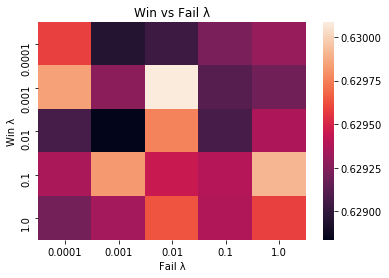

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
#val_histories = np.load('../important/val_histories_regularized.npy')
max_val = np.array([max(val) for val in val_histories])
#train_histories = np.load('../important/train_histories.npy')
#max_train = [max(train_histories) for val in train_histories]
max_val = max_val.reshape(5,5)
cmap = sns.color_palette("rocket")
ax = sns.heatmap(max_val)
ax.set_xticklabels(win_lambs)
plt.xlabel('Fail λ')
ax.set_yticklabels(fail_lambs)
plt.title('Win vs Fail λ')
plt.ylabel('Win λ')
plt.savefig('../plots/bpr_heatmap_win_fail_lamb.png')
plt.show()

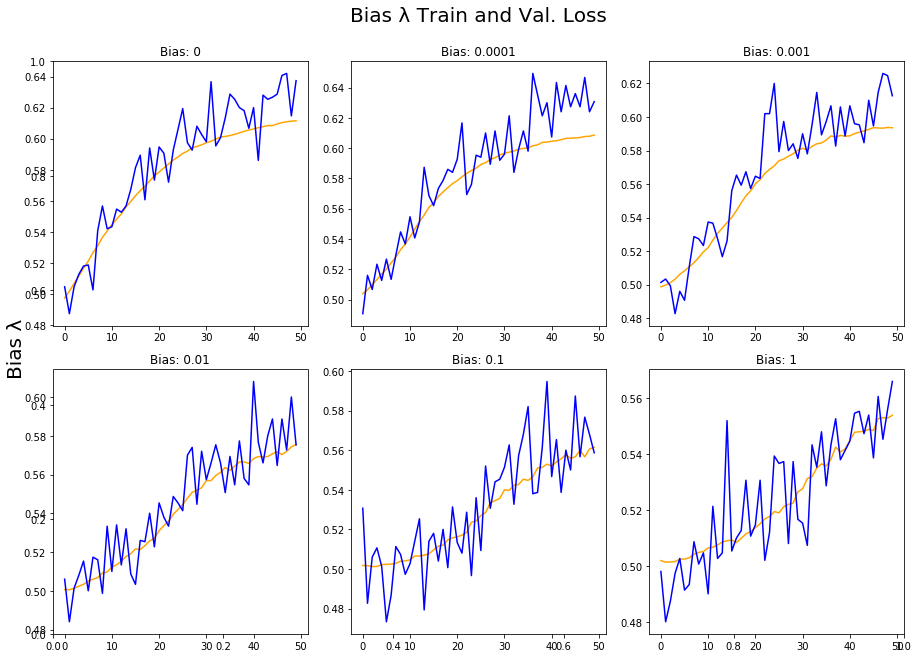

In [28]:
#print(max_vals.index(0.5693705324057472))
import matplotlib.pyplot as plt
reshaped_val = np.array(val_histories).reshape(2,3,50)
reshaped_train = np.array(train_histories).reshape(2,3,50)
lambs = [0,0.0001,0.001,0.01,0.1,1]
fig= plt.figure(figsize=(13,9))
axes = fig.subplots(nrows=2,ncols=3)
main = fig.add_subplot(111, frameon=False)
index = 0
for i in range(2):
    for j in range(3):
        val_data = reshaped_val[i,j]
        train_data= reshaped_train[i,j]
        axes[i,j].plot(val_data,c='orange',label='Validation')
        axes[i,j].plot(train_data,c='blue',label='Training')
        axes[i,j].set_title('Bias: {}'.format(lambs[index]))
        index += 1
plt.tight_layout()
plt.title('Bias λ Train and Val. Loss',size=20,pad=40)
#plt.xlabel('Item λ',size=20)
plt.ylabel('Bias λ',size=20)
plt.savefig('../plots/bias_val_train_acc_.png')
#plt.title("Validation Accuracy vs Training Accuracy for K = 16 & α=0.05")
#plt.plot(val_histories[24],c='orange',label='Validation')
#plt.plot(train_histories[24],c='blue',label='Training')
#plt.legend(loc='best')

In [ ]:
#Load different types of triplet datasets, train and evaluate on each of them
files = ['user_max_matchup.csv','user_ogmeta_rating_matchup.csv','user_attempt_rating_matchup.csv']
for file in files:
    triplets = pd.read_csv('../important/'+file)
    cats = triplets['fail_id'].append(triplets['win_id'])
    cats = cats.astype('category').cat.codes
    triplets['fail_cat'] = cats[:triplets.shape[0]]
    triplets['win_cat'] = cats[triplets.shape[0]:]
    train_data,val_data = train_test(triplets,0.3)
    val_data,test_data = train_test(val_data,0.2)
    uids = train_data['user_cat'].values
    iids = train_data['win_cat'].values
    jids = train_data['fail_cat'].values
    n_users = triplets.user_cat.astype('int32').max() + 1
    n_puzzles = max(triplets.fail_cat.astype('int32').max() + 1,triplets.win_cat.astype('int32').max() + 1)
    lambs = (1,0.01,0.001)
    model = BPRObject(n_users,n_puzzles,16,0.005,lambs,val_data)
    model.launchG(50,50,15000,uids,iids,jids)
    test_acc = model.evaluate(test_data)
    print('Model trained on {}:{}'.format(file,test_acc))

<h2>Prepare Data for Projector</h2>

In [99]:
#Get puzzle embeddings and prepare for the projector
item_vecs = model.get_item_embeddings()
item_frame = pd.DataFrame(item_vecs)
item_frame = item_frame.reindex(lookup['puzzle_id'])

In [100]:
#Load puzzle metadata
puzzle_data = pd.read_csv('../important/tactics_problem_singletag.csv')

In [101]:
print('Saving meta and vecs')
meta_file = pd.merge(lookup,puzzle_data,on='tactics_problem_id',how='left')
meta_file.drop(['pgn','rd','puzzle_id'],axis=1,inplace=True)
meta_file = meta_file.fillna(0)
vec_file_name = '../../ChessPuzzleEmbeddings/rating_bpr/metarating_maxmatchup_vecs.tsv'
meta_file_name = '../../ChessPuzzleEmbeddings/rating_bpr/metarating_maxmatchup_meta.tsv'
item_frame.to_csv(vec_file_name,sep='\t',index=False,header=False)
meta_file.to_csv(meta_file_name,sep='\t',index=False,header=True)

Saving meta and vecs


In [102]:
meta_file.shape

(32239, 9)